In [19]:
# Data Information
train_dataset = 'practiceData3Years.nc'
response_var = 'Temperature'
sensor_var = 'Probe'
# Model Information
num_samples = 200000
num_epochs = 500
batch_size = 64
learning_rate = 0.001
L2 = 0.0001
EarlyStopperPatience = 5
EarlyStopperDelta = 0

In [101]:
# Libraries
import xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import datashader as ds
from datashader.mpl_ext import dsshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print('how many GPUs? = ',torch.cuda.device_count())

False
how many GPUs? =  0


In [ ]:
# Load Training Data - here DynaMO chirp-step cycle data
ds = xarray.open_dataset(train_dataset)
# ds = nc.Dataset(train_dataset)
df_raw = ds.to_dataframe()
# df_raw = pd.read_csv(train_dataset, header=0)
num_rows = df_raw.shape[0]
# num_samples = num_rows
# Randomly sample from data set
df = df_raw.sample(num_samples, random_state=1)
# print(df.head())
# df = df.drop(sensor_var, axis=1)
# log transform
df[response_var] = np.log(df[response_var])
# Normalize and clean data
df_mu = df.mean(axis=0)
df_std = df.std()
df_minusmean = df - df_mu
df_normalized = df_minusmean / df_std
df_dropped = df_normalized.dropna()
df_response = df_dropped.pop(response_var)

# Randomly split into training and test data features and response (80% training / 10% validation / 10% test)
X = np.array(df_dropped)
Y = np.array(df_response)
input_size = X.shape[1]
train_input, valid_test_input, train_output, valid_test_output = train_test_split(X, Y, test_size=0.2)
valid_input, test_input, valid_output, test_output = train_test_split(valid_test_input, valid_test_output, test_size=0.5)

# Convert to tensors
train_x = torch.from_numpy(np.float32(train_input))
train_y = torch.from_numpy(np.float32(train_output))
valid_x = torch.from_numpy(np.float32(valid_input))
valid_y = torch.from_numpy(np.float32(valid_output))
test_x = torch.from_numpy(np.float32(test_input))
test_y = torch.from_numpy(np.float32(test_output))
train_y = train_y.unsqueeze(1)
valid_y = valid_y.unsqueeze(1)
test_y = test_y.unsqueeze(1)
# Send tensors to GPU
# train_x = train_x.to(device)
# train_y = train_y.to(device)
# valid_x = valid_x.to(device)
# valid_y = valid_y.to(device)
# test_x = test_x.to(device)
# test_y = test_y.to(device)

In [37]:
len(test_output)

19087

In [22]:
# Define Model
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
net = Net()
net.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=L2)
print(net)

Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=1, bias=True)
)


In [23]:
# Early Stopping Function
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
early_stopper = EarlyStopper(patience=EarlyStopperPatience, min_delta=EarlyStopperDelta)

In [24]:
# Load Model
net = Net()
net.load_state_dict(torch.load(r'C:\Users\boltm\OneDrive - purdue.edu\!Junior2\Research\OTEC_miniBatchState.pth'))
net.eval()

Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=1, bias=True)
)

In [83]:
# Evaluate with Model
# Test Model
test_predictions = net(test_x).detach()
test_predictions = test_predictions.squeeze(1)
test_predictions = test_predictions.numpy()
# UnNormalizing and undoing log transform
test_predictions_unstandardized = test_predictions * df_std[response_var]
test_predictions_remean = test_predictions_unstandardized + df_mu[response_var]
test_predictions_restored = np.exp(test_predictions_remean)

test_labels_unstandardized = test_output * df_std[response_var]
test_labels_remean = test_labels_unstandardized + df_mu[response_var]
test_labels_restored = np.exp(test_labels_remean)

In [84]:
# Error Metric Calculation
rms = mean_squared_error(test_labels_restored, test_predictions_restored)
nrms = rms / (df_mu[response_var])
R2 = r2_score(test_labels_restored, test_predictions_restored)
print("Test Data Error Metrics")
print("RMSE = {:.4f}".format(rms))
print("NRMSE = {:.4f}".format(nrms))
print("R2 = {:.4f}".format(R2))

Test Data Error Metrics
RMSE = 1.6447
NRMSE = 0.9261
R2 = 0.9731


In [85]:
# Loss Plot
epoch_list = range(epoch+1)
fig, ax = plt.subplots(dpi = 150)
ax.plot(epoch_list, tloss, 'k-')
ax.plot(epoch_list, vloss, 'b-')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(['Training Loss', 'Validation Loss'])
ax.set_title('Loss Plot')
plt.savefig('Loss Plot.png')

NameError: name 'epoch' is not defined

In [94]:
xy = np.vstack([test_labels_restored, test_predictions_restored])
z = gaussian_kde(xy)(xy)
print(z.shape)

(19087,)


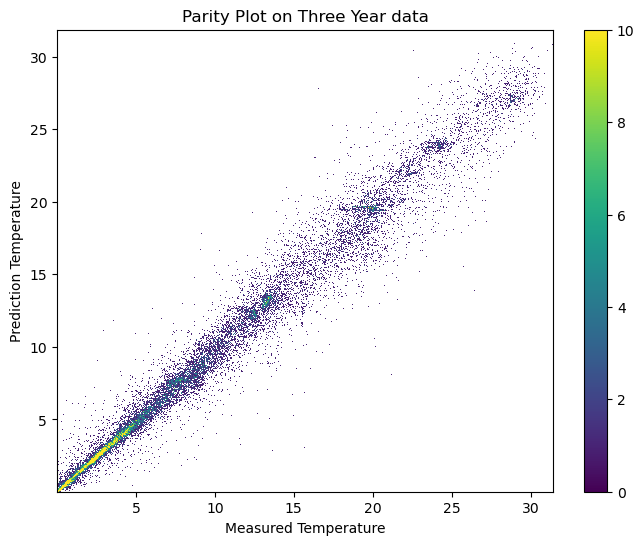

In [119]:
def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=10,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(test_labels_restored,test_labels_restored,'b-')
using_datashader(ax, test_labels_restored, test_predictions_restored)
ax.set_xlabel('Measured Temperature')
ax.set_ylabel('Prediction Temperature')
ax.set_title('Parity Plot on Three Year data')
plt.show()

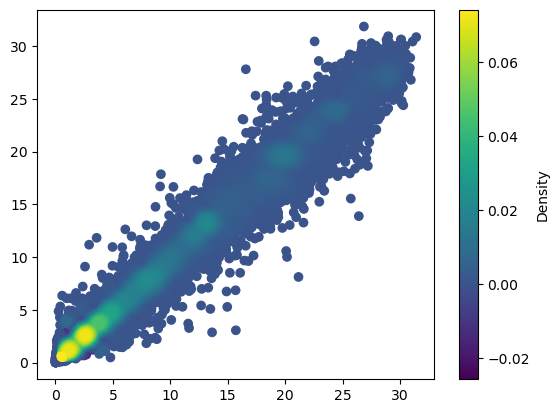

In [99]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax


if "__main__" == __name__ :
    density_scatter(test_labels_restored, test_predictions_restored, bins = [30,30] )

ValueError: array([2.37006399e-05, 2.37007291e-05, 2.37010166e-05, ...,
       9.10801246e-02, 9.10807355e-02, 9.10840055e-02]) is not a valid value for color

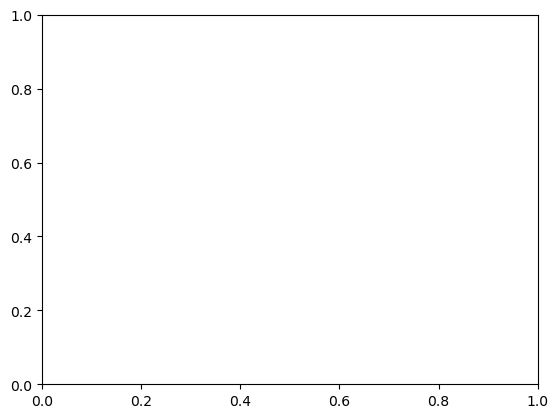

In [96]:
# Parity Plot
fig, ax = plt.subplots(dpi = 100)
ax.plot(test_labels_restored, test_predictions_restored, c=z, s=50)
# ax.plot(test_labels_restored, test_predictions_restored, 'o')
ax.plot(test_labels_restored,test_labels_restored,'r-')
ax.set_xlabel('Measured Temperature')
ax.set_ylabel('Prediction Temperature')
ax.set_title('Parity Plot on Three Year data')
plt.show()